In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

print(X_motion.shape)
print(Y_motion.shape)

(6432, 24)
(6432, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging[10]

array([ 0.1       ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.23616482,  0.13015154, -0.38201863,  0.25241366,
       -0.13181412, -0.37140876, -0.2450209 ,  0.12336481, -0.37529954,
       -0.26236087, -0.12950508, -0.38197994,  0.06644741, -0.02615376,
       -0.03864057,  0.00386342,  1.        ,  0.        ])

In [9]:
X_motion_FL_swinging[10, 18:22]

array([ 0.06644741, -0.02615376, -0.03864057,  0.00386342])

In [10]:
Y_motion_FL_swinging.shape

(3214, 4)

In [11]:
X_motion_FL_swinging[0:10, 0]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               #X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9733501896779498
RMSE:  0.020387973489223762
The lowest error is:  1.1974435499495506e-05
The highest error is:  0.11043395657550226
The avg. error is:  0.01392091188365364


In [21]:
model_fl_relative_support_x.coef_

array([[ 5.80524114e-03, -4.44089210e-16, -8.88178420e-16,
         2.06302299e-01,  2.22044605e-16,  2.22044605e-16,
         3.29927326e-01, -9.99173583e-01,  4.46565389e-01,
         1.47872526e+00,  2.64613473e-01,  1.92678948e-01,
        -2.58514598e+00, -1.20729352e+00]])

In [22]:
model_fl_relative_support_x.intercept_

array([-0.64821702])

Text(0, 0.5, 'Predictions')

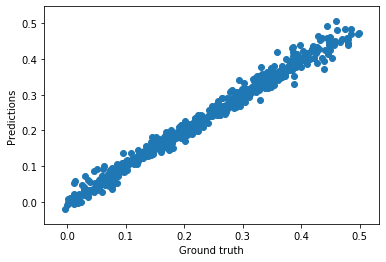

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [23]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               #X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.06682749112798592
RMSE:  0.007555000805657899
The lowest error is:  2.555470053841602e-05
The highest error is:  0.04409088225986854
The avg. error is:  0.0053094489707521415


In [24]:
model_fl_relative_support_y.coef_

array([[ 2.67892269e-03,  1.38777878e-17, -6.55725474e-16,
         9.70699168e-03,  0.00000000e+00,  1.11022302e-16,
         2.62501821e-01, -1.35041414e+00,  1.16711768e-01,
         3.57393160e-01, -2.04400017e-01,  4.73268162e-01,
        -4.93680102e-01, -4.44433434e-01]])

In [25]:
model_fl_relative_support_y.intercept_

array([-0.17506776])

Text(0, 0.5, 'Predictions')

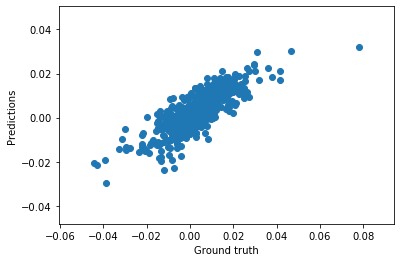

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')